# Attention Is All You Need

This notebook implements the model in:  
Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., Kaiser, L., and Polosukhin, I. 2017. Attention is all you need. In Advances in neural information processing systems, 5998-6008. [arXiv:1706.03762](https://arxiv.org/abs/1706.03762).  

This model is based on an *Encoder-Decoder* framework, in which the encoder and the decoder are both based on Self-Attention.  
Refer to [Vaswani et al. (2017)](https://arxiv.org/abs/1706.03762) or my blogs ([Attention is All You Need](https://syuoni.github.io/posts/Attention-is-All-You-Need/), [Attention in NLP](https://syuoni.github.io/posts/Attention-in-NLP/)) for more details.  

![Transformer](fig/transformer.png)

In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

SEED = 515
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Preparing Data

In [2]:
import spacy
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

def tokenize_de(text):
    """
    Tokenize German text. 
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenize English text.
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [3]:
from torchtext.data import Field, BucketIterator

# Set `batch_first=True` in the `Field`.
SRC = Field(tokenize=tokenize_de, init_token='<sos>', eos_token='<eos>', 
            lower=True, include_lengths=True, batch_first=True)
TRG = Field(tokenize=tokenize_en, init_token='<sos>', eos_token='<eos>', 
            lower=True, include_lengths=True, batch_first=True)

In [4]:
from torchtext.datasets import Multi30k

train_data, valid_data, test_data = Multi30k.splits(exts=['.de', '.en'], 
                                                    # fields=[SRC, TRG], 
                                                    fields=[('src', SRC), ('trg', TRG)], 
                                                    root="../assets/data")

In [5]:
print(train_data[0].src)
print(train_data[0].trg)

['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.']
['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']


In [6]:
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

len(SRC.vocab), len(TRG.vocab)

(7854, 5893)

In [7]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=BATCH_SIZE, device=device)

In [8]:
for batch in train_iterator:
    batch_src, batch_src_lens = batch.src
    batch_trg, batch_trg_lens = batch.trg
    break
print(batch_src)
print(batch_src_lens)
print(batch_trg)
print(batch_trg_lens)

tensor([[  2,   5,  13,  ...,   1,   1,   1],
        [  2,   5,  13,  ...,   1,   1,   1],
        [  2,  43, 253,  ...,   1,   1,   1],
        ...,
        [  2,   5,  13,  ...,   1,   1,   1],
        [  2,  18,  30,  ...,   1,   1,   1],
        [  2,  18,   0,  ...,   1,   1,   1]], device='cuda:0')
tensor([14, 17, 12, 11, 17, 21, 12, 16, 14, 11, 23, 23,  8, 11,  9, 14, 19, 20,
        12, 16,  9, 11, 13, 20, 21, 29, 13, 22, 14, 16, 10,  9, 15, 12, 17, 10,
        14, 22, 17, 20, 23, 23, 12, 17, 15, 19, 17, 15, 16,  7, 14, 15, 16, 12,
        17, 14, 18, 18, 14, 14, 17, 21, 12, 12,  9, 19, 12, 14, 12, 11, 10, 13,
        18, 14,  9, 11, 10, 12, 10, 25, 14, 18, 15, 16, 15, 18, 13,  9, 21, 11,
        20, 12, 13, 14, 14, 17, 10, 13, 18, 30, 14, 12, 13,  9, 10, 15, 13, 10,
        12, 15, 13, 18, 17, 13, 11, 12, 10, 16, 12, 13, 24, 14, 19, 19, 10, 20,
        12, 11], device='cuda:0')
tensor([[   2,    4,    9,  ...,    1,    1,    1],
        [   2,    4,    9,  ...,    1,    1,   

## Building the Model
### Multi-Head Attention

![Transformer Attention](fig/transformer-attention.png)

In [9]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_m: int, d_k: int, d_v: int, n_heads: int, dropout: float):
        super().__init__()
        self.d_m = d_m
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads

        self.WQ = nn.Linear(d_m, d_k*n_heads)
        self.WK = nn.Linear(d_m, d_k*n_heads)
        self.WV = nn.Linear(d_m, d_v*n_heads)
        self.WO = nn.Linear(d_v*n_heads, d_m)

        self.dropout = nn.Dropout(dropout)

    def scaled_dotproduct(self, Q: torch.Tensor, K: torch.Tensor, V: torch.Tensor, 
                          mask: torch.Tensor):
        # Q: (batch, head, trg_step, d_k)
        # K: (batch, head, src_step, d_k)
        # V: (batch, head, src_step, d_v)
        # mask: (batch, trg_step, src_step)

        # energy/attens: (batch, head, trg_step, src_step)
        energy = Q.matmul(K.permute(0, 1, 3, 2)) / (self.d_k ** 0.5)
        energy.masked_fill_(mask.unsqueeze(1), -np.inf)
        attens = F.softmax(energy, dim=-1)
        # Note: Why applying dropout on attention?
        # attened_values: (batch, head, trg_step, d_v)
        return self.dropout(attens).matmul(V), attens

    def forward(self, Q: torch.Tensor, K: torch.Tensor, V: torch.Tensor, 
                mask: torch.Tensor):
        # Q/K/V: (batch, src_step/trg_step, d_m)
        # mask: (batch, trg_step, src_step)

        # Q: (batch, head, trg_step, d_k)
        # K: (batch, head, src_step, d_k)
        # V: (batch, head, src_step, d_v)
        Q = self.WQ(Q).view(Q.size(0), -1, self.n_heads, self.d_k).permute(0, 2, 1, 3)
        K = self.WK(K).view(K.size(0), -1, self.n_heads, self.d_k).permute(0, 2, 1, 3)
        V = self.WV(V).view(V.size(0), -1, self.n_heads, self.d_v).permute(0, 2, 1, 3)
        # attened_values: (batch, head, trg_step, d_v)
        # attens: (batch, head, trg_step, src_step)
        attened_values, attens = self.scaled_dotproduct(Q, K, V, mask)

        attened_values = attened_values.permute(0, 2, 1, 3).contiguous()
        attened_values = attened_values.view(attened_values.size(0), -1, self.d_v*self.n_heads)
        # attened_values: (batch, trg_step, d_m)
        return self.WO(attened_values), attens

In [10]:
SRC_IN_DIM = len(SRC.vocab)
TRG_IN_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1
ENC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
DEC_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

attention = MultiHeadAttention(HID_DIM, HID_DIM//ENC_HEADS, HID_DIM//ENC_HEADS, 
                               ENC_HEADS, ENC_DROPOUT).to(device)
src_emb = nn.Embedding(SRC_IN_DIM, HID_DIM, padding_idx=ENC_PAD_IDX).to(device)
trg_emb = nn.Embedding(TRG_IN_DIM, HID_DIM, padding_idx=DEC_PAD_IDX).to(device)

# mask: (batch, trg_step=1, src_step)
mask = (batch_src == src_emb.padding_idx).unsqueeze(1)
# K: (src_step, batch, hid_dim)
K = src_emb(batch_src)
# Q: (trg_step, batch, hid_dim)
Q = trg_emb(batch_trg)
attened_values, attens = attention(Q, K, K, mask)

print(batch_src.size())
print(batch_trg.size())
print(attens.size())
print(attened_values.size())

torch.Size([128, 30])
torch.Size([128, 29])
torch.Size([128, 8, 29, 30])
torch.Size([128, 29, 256])


In [11]:
print((attens.sum(dim=-1) - 1).abs().max())
print(((attens == 0) == mask.unsqueeze(1)).all())

tensor(2.3842e-07, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(True, device='cuda:0')


### Position-Wise Feedforward Layer

In [12]:
class PosWiseFFN(nn.Module):
    def __init__(self, hid_dim: int, ffn_dim: int, dropout: float):
        super().__init__()

        self.fc1 = nn.Linear(hid_dim, ffn_dim)
        self.fc2 = nn.Linear(ffn_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor):
        x = self.fc1(x)
        x = self.dropout(F.relu(x))
        return self.fc2(x)

In [13]:
ffn = PosWiseFFN(HID_DIM, ENC_PF_DIM, ENC_DROPOUT).to(device)
print(K.size())
print(ffn(K).size())

torch.Size([128, 30, 256])
torch.Size([128, 30, 256])


### Encoder Layer
`Layer Normalization` over a mini-batch: 
$$
y = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta
$$
where $\gamma$ and $\beta$ are learnable parameters in shape of `normalized_shape`.  
`nn.LayerNorm(normalized_shape)`: The mean and standard-deviation are calculated separately over the last certain number dimensions which have to be of the shape specified by `normalized_shape`.

In [14]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim: int, n_heads: int, ffn_dim: int, dropout: float):
        super().__init__()
        assert hid_dim % n_heads == 0

        self.self_attention = MultiHeadAttention(hid_dim, hid_dim//n_heads, hid_dim//n_heads, 
                                                 n_heads, dropout)
        self.self_atten_layer_norm = nn.LayerNorm(hid_dim)
        self.ffn = PosWiseFFN(hid_dim, ffn_dim, dropout)
        self.ffn_layer_norm = nn.LayerNorm(hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, mask: torch.Tensor):
        # x: (batch, src_step, hid_dim)
        # mask: (batch, 1, src_step)

        # attened: (batch, src_step, hid_dim)
        # attens: (batch, head, src_step, src_step)
        attened, attens = self.self_attention(x, x, x, mask)
        attened_x_comb = self.self_atten_layer_norm(x + self.dropout(attened))

        ffned = self.ffn(attened_x_comb)
        ffned_attened_x_comb = self.ffn_layer_norm(attened_x_comb + self.dropout(ffned))
        return ffned_attened_x_comb, attens

In [15]:
encoder_layer = EncoderLayer(HID_DIM, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT).to(device)

outs, attens = encoder_layer(K, mask)
print(outs.size())
print(attens.size())

torch.Size([128, 30, 256])
torch.Size([128, 8, 30, 30])


### Encoder
* Use Self-Attention instead of RNN.  
* *Token Embeddings* + *Positional Embeddings*.  
* Encoder Layers  
    * Self-Attention -> LayerNorm
    * Position-Wise FFN -> LayerNorm   
    * Residual Connection

![Transformer Encoder](fig/transformer-encoder.png)

In [16]:
class Encoder(nn.Module):
    def __init__(self, in_dim: int, hid_dim: int, ffn_dim: int, n_layers: int, 
                 n_heads: int, dropout: float, pad_idx: int, max_len: int=100):
        super().__init__()
        self.tok_emb = nn.Embedding(in_dim, hid_dim, padding_idx=pad_idx)
        self.pos_emb = nn.Embedding(max_len, hid_dim)

        self.layers = nn.ModuleList([EncoderLayer(hid_dim, n_heads, ffn_dim, dropout) 
                                     for _ in range(n_layers)])

        self.dropout = nn.Dropout(dropout)
        self.scale = hid_dim ** 0.5

    def forward(self, src: torch.Tensor, mask: torch.Tensor):
        # src: (batch, src_step)
        # mask: (batch, 1, src_step)
        pos = torch.arange(src.size(1), device=src.device).repeat(src.size(0), 1)
        
        # Element-wise addition
        # embedded: (batch, src_step, hid_dim)
        embedded = self.tok_emb(src)*self.scale + self.pos_emb(pos)
        embedded = self.dropout(embedded)

        # Note: Does here need masking?
        # NO. Although the padding positions may be polluted in the self-attention layer, 
        # The elements in padding positions are impossible to pass to valid (non-padding)
        # positions, as long as the self-attention is applied with masking. 
        x = embedded
        for i, layer in enumerate(self.layers):
            x, attens = layer(x, mask)
        # x: (batch, src_step, hid_dim)
        # attens: (batch, head, src_step, src_step)
        return x, attens

In [17]:
encoder = Encoder(SRC_IN_DIM, HID_DIM, ENC_PF_DIM, ENC_LAYERS, ENC_HEADS,  
                  ENC_DROPOUT, ENC_PAD_IDX).to(device)

# mask: (batch, 1, src_step)
mask = (batch_src == encoder.tok_emb.padding_idx).unsqueeze(1)
enc_outs, attens = encoder(batch_src, mask)

print(batch_src.size())
print(enc_outs.size())
print(attens.size())

torch.Size([128, 30])
torch.Size([128, 30, 256])
torch.Size([128, 8, 30, 30])


### Decoder Layer

In [18]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim: int, n_heads: int, ffn_dim: int, dropout: float):
        super().__init__()
        assert hid_dim % n_heads == 0

        self.self_attention = MultiHeadAttention(hid_dim, hid_dim//n_heads, hid_dim//n_heads, 
                                                 n_heads, dropout)
        self.self_atten_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attention = MultiHeadAttention(hid_dim, hid_dim//n_heads, hid_dim//n_heads, 
                                                n_heads, dropout)
        self.enc_atten_layer_norm = nn.LayerNorm(hid_dim)
        self.ffn = PosWiseFFN(hid_dim, ffn_dim, dropout)
        self.ffn_layer_norm = nn.LayerNorm(hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, y: torch.Tensor, x: torch.Tensor, 
                trg_mask: torch.Tensor, src_mask: torch.Tensor):
        # x/y: (batch, src_step/trg_step, hid_dim)
        # trg_mask: (batch, trg_step, trg_step)
        # src_mask: (batch, 1, src_step)

        # self_attened: (batch, trg_step, hid_dim)
        # self_attens: (batch, head, trg_step, trg_step)
        self_attened, self_attens = self.self_attention(y, y, y, trg_mask)
        sa_y_comb = self.self_atten_layer_norm(y + self.dropout(self_attened))

        # enc_attened: (batch, trg_step, hid_dim)
        # enc_attens: (batch, head, trg_step, src_step)
        enc_attened, enc_attens = self.enc_attention(sa_y_comb, x, x, src_mask)
        ea_sa_y_comb = self.enc_atten_layer_norm(sa_y_comb + self.dropout(enc_attened))

        ffned = self.ffn(ea_sa_y_comb)
        ffned_ea_sa_y_comb = self.ffn_layer_norm(ea_sa_y_comb + self.dropout(ffned))
        return ffned_ea_sa_y_comb, self_attens, enc_attens

### Decoder
* Use Self-Attention instead of RNN.  
* *Token Embeddings* + *Positional Embeddings*.  
* Decoder Layers  
    * Self-Attention -> LayerNorm
    * Encoder-Attention -> LayerNorm
    * Position-Wise FFN -> LayerNorm   
    * Residual Connection

![Transformer Decoder](fig/transformer-decoder.png)

In [19]:
class Decoder(nn.Module):
    def __init__(self, in_dim: int, hid_dim: int, ffn_dim: int, n_layers: int, 
                 n_heads: int, dropout: float, pad_idx: int, max_len: int=100):
        super().__init__()
        self.tok_emb = nn.Embedding(in_dim, hid_dim, padding_idx=pad_idx)
        self.pos_emb = nn.Embedding(max_len, hid_dim)

        self.layers = nn.ModuleList([DecoderLayer(hid_dim, n_heads, ffn_dim, dropout) 
                                     for _ in range(n_layers)])

        self.fc = nn.Linear(hid_dim, in_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = hid_dim ** 0.5

    def forward(self, trg: torch.Tensor, enc_outs: torch.Tensor, 
                trg_mask: torch.Tensor, src_mask: torch.Tensor):
        # trg: (batch, trg_step)
        # enc_outs: (batch, src_step, hid_dim)
        # trg_mask: (batch, trg_step, trg_step)
        # src_mask: (batch, 1, src_step)
        pos = torch.arange(trg.size(1), device=trg.device).repeat(trg.size(0), 1)
        
        # Element-wise addition
        # embedded: (batch, trg_step, hid_dim)
        embedded = self.tok_emb(trg)*self.scale + self.pos_emb(pos)
        embedded = self.dropout(embedded)

        # Note: Does here need masking?
        # NO. Although the padding positions may be polluted in the self-attention layer, 
        # The elements in padding positions are impossible to pass to valid (non-padding)
        # positions, as long as the self-attention is applied with masking. 
        y = embedded
        for i, layer in enumerate(self.layers):
            y, self_attens, enc_attens = layer(y, enc_outs, trg_mask, src_mask)
        # y: (batch, trg_step, hid_dim)
        # self_attens: (batch, head, trg_step, trg_step)
        # enc_attens: (batch, head, trg_step, src_step)
        return self.fc(y), self_attens, enc_attens

### The Mask on Target Sequence for Decoder's Self-Attention
The mask on target sequence is "subsequent" masking, which forbids the decoder to obtain information from subsequent steps. For example, the target sequence length is 5; the queries are $\{ q_1, q_2, \dots, q_5 \}$, and the keys/values are $\{ k_1/v_1, k_2/v_2, \dots, k_5/v_5 \}$ (They are actually the same vectors). The masking matrix should be:  
$$
\begin{matrix}
& k_1/v_1 & k_2/v_2 & k_3/v_3 & k_4/v_4 & k_5/v_5\\
q_1 & False & True  & True  & True  & True\\
q_2 & False & False & True  & True  & True\\
q_3 & False & False & False & True  & True\\
q_4 & False & False & False & False & True\\
q_5 & False & False & False & False & False\\
\end{matrix}
$$
where $True$ denotes `masked` and $False$ denotes `not-masked`.  

#### Do we need to consider the masking for padding positions?  
NO. Because they will be ignored in the loss function. Or if so, when using the model for inference, we have no idea where the padding positions are, and we cannot create a masking for them.  

In [20]:
# Use `torch.triu` to create the masking matrix
torch.ones(5, 5, dtype=torch.bool).triu(1)

tensor([[False,  True,  True,  True,  True],
        [False, False,  True,  True,  True],
        [False, False, False,  True,  True],
        [False, False, False, False,  True],
        [False, False, False, False, False]])

In [21]:
decoder = Decoder(TRG_IN_DIM, HID_DIM, DEC_PF_DIM, DEC_LAYERS, DEC_HEADS,  
                  DEC_DROPOUT, DEC_PAD_IDX).to(device)

# src_mask: (batch, 1, src_step)
src_mask = (batch_src == encoder.tok_emb.padding_idx).unsqueeze(1)
# `trg_mask` is "subsequent" masking, which forbids the decoder to obtain information 
# from subsequent steps. 
# trg_mask: (batch=1, trg_step, trg_step)
trg_mask = torch.ones(batch_trg.size(1), batch_trg.size(1), dtype=torch.bool, 
                      device=device).triu(1).unsqueeze(0)

dec_outs, self_attens, enc_attens = decoder(batch_trg, enc_outs, trg_mask, src_mask)

print(batch_src.size())
print(batch_trg.size())
print(dec_outs.size())
print(self_attens.size())
print(enc_attens.size())

torch.Size([128, 30])
torch.Size([128, 29])
torch.Size([128, 29, 5893])
torch.Size([128, 8, 29, 29])
torch.Size([128, 8, 29, 30])


### Seq2Seq

In [22]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder: Encoder, decoder: Decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src: torch.Tensor, trg: torch.Tensor):
        # src: (batch, src_step)
        # trg: (batch, trg_step-1)
        # For the target sequence, the `<eos>` token should be sliced off before passing to the decoder. 
        # As there are no more tokens to be predicted after `<eos>`. 
        trg = trg[:, :-1]

        # src_mask: (batch, 1, src_step)
        # trg_mask: (batch=1, trg_step-1, trg_step-1)
        src_mask = (src == self.encoder.tok_emb.padding_idx).unsqueeze(1)
        trg_mask = torch.ones(trg.size(1), trg.size(1), dtype=torch.bool, 
                              device=trg.device).triu(1).unsqueeze(0)

        enc_outs, enc_self_attens = self.encoder(src, src_mask)
        dec_outs, dec_self_attens, dec_enc_attens = self.decoder(trg, enc_outs, trg_mask, src_mask)

        # dec_outs: (batch, trg_step-1, trg_out_dim)
        # enc_self_attens: (batch, head, src_step, src_step)
        # dec_self_attens: (batch, head, trg_step-1, trg_step-1)
        # dec_enc_attens: (batch, head, trg_step-1, src_step)
        return dec_outs, enc_self_attens, dec_self_attens, dec_enc_attens

    def translate(self, src: torch.Tensor, sos: int, trg_max_len: int=50):
        # Ensure `dropout` off, or the result would change randomly. 
        self.eval()
        # src: (batch, src_step)
        # src_mask: (batch, 1, src_step)
        src_mask = (src == self.encoder.tok_emb.padding_idx).unsqueeze(1)
        enc_outs, enc_self_attens = self.encoder(src, src_mask)

        # Create an target sequence. 
        # trg: (batch, trg_step)
        trg = torch.ones(src.size(0), trg_max_len, 
                         dtype=torch.long, device=src.device) * sos

        # The inference would be slow, since there is much repeated computation. 
        for t in range(1, trg.size(1)):
            # (2) The input target sequence should be `trg[:, :(t+1)]`; with `<eos>` token sliced off, 
            # it becomes `trg[:, :t]`. Note that the elements in step `t-1` is just predicted in the 
            # last loop.  
            # trg_mask_t: (batch=1, trg_step-1=t, trg_step-1=t)
            # dec_outs_t: (batch, trg_step-1=t, trg_out_dim)
            trg_mask_t = torch.ones(t, t, dtype=torch.bool, device=trg.device).triu(1).unsqueeze(0)
            dec_outs_t, dec_self_attens_t, dec_enc_attens_t = self.decoder(trg[:, :t], enc_outs, trg_mask_t, src_mask)

            # top1: (batch, )
            top1 = dec_outs_t[:, -1].argmax(dim=-1)
            trg[:, t] = top1
            
        # The decoder's output at the last step is the desired result (over all steps). 
        # `trg[:, 1:]` equals `dec_outs_t.argmax(dim=-1)` - if the `dropout` off
        assert (trg[:, 1:] == dec_outs_t.argmax(dim=-1)).all().item()
        return trg[:, 1:], enc_self_attens, dec_self_attens_t, dec_enc_attens_t

In [23]:
model = Seq2Seq(encoder, decoder).to(device)
preds, *_ = model(batch_src, batch_trg)

print(batch_src.size())
print(batch_trg.size())
print(preds.size())

torch.Size([128, 30])
torch.Size([128, 29])
torch.Size([128, 28, 5893])


In [24]:
DEC_SOS_IDX = TRG.vocab.stoi[TRG.init_token]
DEC_EOS_IDX = TRG.vocab.stoi[TRG.eos_token]
pred_indexes, enc_self_attens, dec_self_attens, dec_enc_attens = model.translate(batch_src, DEC_SOS_IDX)

print(pred_indexes.size())
print(enc_self_attens.size())
print(dec_self_attens.size())
print(dec_enc_attens.size())

torch.Size([128, 49])
torch.Size([128, 8, 30, 30])
torch.Size([128, 8, 49, 49])
torch.Size([128, 8, 49, 30])


In [25]:
# Check if data are mixed across different samples in a batch.
model.eval()
preds_012, *_ = model(batch_src[0:3], batch_trg[0:3])
preds_123, *_ = model(batch_src[1:4], batch_trg[1:4])
(preds_012[1:] == preds_123[:2]).all()

tensor(True, device='cuda:0')

## Training the Model

In [26]:
# This is important...
def init_weights(m: nn.Module):
    for name, param in m.named_parameters():
        if 'weight' in name and param.dim() > 1:
            nn.init.xavier_uniform_(param.data)

def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

encoder = Encoder(SRC_IN_DIM, HID_DIM, ENC_PF_DIM, ENC_LAYERS, ENC_HEADS,  
                  ENC_DROPOUT, ENC_PAD_IDX).to(device)
decoder = Decoder(TRG_IN_DIM, HID_DIM, DEC_PF_DIM, DEC_LAYERS, DEC_HEADS,  
                  DEC_DROPOUT, DEC_PAD_IDX).to(device)
model = Seq2Seq(encoder, decoder).to(device)

model.apply(init_weights)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,038,597 trainable parameters


In [27]:
# Initialize Embeddings 
ENC_UNK_IDX = SRC.vocab.stoi[SRC.unk_token]
DEC_UNK_IDX = TRG.vocab.stoi[TRG.unk_token]

model.encoder.tok_emb.weight.data[ENC_UNK_IDX].zero_()
model.encoder.tok_emb.weight.data[ENC_PAD_IDX].zero_()
model.decoder.tok_emb.weight.data[DEC_UNK_IDX].zero_()
model.decoder.tok_emb.weight.data[DEC_PAD_IDX].zero_()

print(model.encoder.tok_emb.weight[:5, :8])
print(model.decoder.tok_emb.weight[:5, :8])

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.0180, -0.0259, -0.0261, -0.0103,  0.0056,  0.0044, -0.0077, -0.0074],
        [-0.0071, -0.0138, -0.0221,  0.0135,  0.0250,  0.0063, -0.0048, -0.0015],
        [ 0.0034,  0.0112,  0.0235,  0.0206, -0.0164,  0.0187, -0.0015, -0.0263]],
       device='cuda:0', grad_fn=<SliceBackward>)
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.0156,  0.0029,  0.0217,  0.0062, -0.0024,  0.0075,  0.0051,  0.0225],
        [-0.0106,  0.0039, -0.0250, -0.0027,  0.0117,  0.0047, -0.0280,  0.0087],
        [ 0.0225,  0.0231, -0.0252,  0.0168, -0.0142,  0.0171,  0.0020,  0.0225]],
       device='cuda:0', grad_fn=<SliceBackward>)


In [28]:
loss_func = nn.CrossEntropyLoss(ignore_index=DEC_PAD_IDX, reduction='mean')
# The `lr` is important...
optimizer = optim.AdamW(model.parameters(), lr=0.0005)

In [29]:
def train_epoch(model, iterator, optimizer, loss_func, clip):
    model.train()
    epoch_loss = 0
    for batch in iterator:
        # Forward pass
        batch_src, batch_src_lens = batch.src
        batch_trg, batch_trg_lens = batch.trg
        # preds: (batch, trg_step-1, trg_out_dim)
        preds, *_ = model(batch_src, batch_trg)
        
        # Calculate loss
        preds_flattened = preds.view(-1, preds.size(-1))
        batch_trg_flattened = batch_trg[:, 1:].flatten()
        loss = loss_func(preds_flattened, batch_trg_flattened)

        # Backward propagation
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)

        # Update weights
        optimizer.step()
        # Accumulate loss
        epoch_loss += loss.item()
    return epoch_loss/len(iterator)

def eval_epoch(model, iterator, loss_func):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for batch in iterator:
            # Forward pass
            batch_src, batch_src_lens = batch.src
            batch_trg, batch_trg_lens = batch.trg
            # preds: (batch, trg_step-1, trg_out_dim)
            preds, *_ = model(batch_src, batch_trg)
            
            # Calculate loss
            preds_flattened = preds.view(-1, preds.size(-1))
            batch_trg_flattened = batch_trg[:, 1:].flatten()
            loss = loss_func(preds_flattened, batch_trg_flattened)
            
            # Accumulate loss and acc
            epoch_loss += loss.item()
    return epoch_loss/len(iterator)

In [30]:
import time
N_EPOCHS = 10
CLIP = 1
best_valid_loss = np.inf

for epoch in range(N_EPOCHS):
    t0 = time.time()
    train_loss = train_epoch(model, train_iterator, optimizer, loss_func, CLIP)
    valid_loss = eval_epoch(model, valid_iterator, loss_func)
    epoch_secs = time.time() - t0

    epoch_mins, epoch_secs = int(epoch_secs // 60), int(epoch_secs % 60)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "models/tut6-model.pt")
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {np.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {np.exp(valid_loss):7.3f}')

Epoch: 01 | Epoch Time: 0m 14s
	Train Loss: 4.229 | Train PPL:  68.635
	 Val. Loss: 3.061 |  Val. PPL:  21.348
Epoch: 02 | Epoch Time: 0m 15s
	Train Loss: 2.842 | Train PPL:  17.158
	 Val. Loss: 2.332 |  Val. PPL:  10.303
Epoch: 03 | Epoch Time: 0m 15s
	Train Loss: 2.249 | Train PPL:   9.476
	 Val. Loss: 2.002 |  Val. PPL:   7.404
Epoch: 04 | Epoch Time: 0m 15s
	Train Loss: 1.890 | Train PPL:   6.619
	 Val. Loss: 1.829 |  Val. PPL:   6.225
Epoch: 05 | Epoch Time: 0m 15s
	Train Loss: 1.638 | Train PPL:   5.147
	 Val. Loss: 1.717 |  Val. PPL:   5.570
Epoch: 06 | Epoch Time: 0m 15s
	Train Loss: 1.450 | Train PPL:   4.264
	 Val. Loss: 1.671 |  Val. PPL:   5.315
Epoch: 07 | Epoch Time: 0m 15s
	Train Loss: 1.297 | Train PPL:   3.660
	 Val. Loss: 1.637 |  Val. PPL:   5.142
Epoch: 08 | Epoch Time: 0m 16s
	Train Loss: 1.169 | Train PPL:   3.218
	 Val. Loss: 1.625 |  Val. PPL:   5.077
Epoch: 09 | Epoch Time: 0m 15s
	Train Loss: 1.062 | Train PPL:   2.891
	 Val. Loss: 1.643 |  Val. PPL:   5.171
E

In [31]:
model.load_state_dict(torch.load("models/tut6-model.pt", map_location=device))

valid_loss = eval_epoch(model, valid_iterator, loss_func)
test_loss = eval_epoch(model, test_iterator, loss_func)

print(f'Val. Loss: {valid_loss:.3f} |  Val. PPL: {np.exp(valid_loss):7.3f}')
print(f'Test Loss: {test_loss:.3f} |  Test PPL: {np.exp(test_loss):7.3f}')

Val. Loss: 1.625 |  Val. PPL:   5.077
Test Loss: 1.687 |  Test PPL:   5.401


## Check Embeddings
* The Embeddings of `<unk>` and `<pad>` tokens
    * Because the `padding_idx` has been passed to `nn.Embedding`, so the `<pad>` embedding will remain zeros throughout training.  
    * While the `<unk>` embedding will be learned.

In [32]:
print(model.encoder.tok_emb.weight[:5, :8])
print(model.decoder.tok_emb.weight[:5, :8])

tensor([[-0.0038,  0.0228,  0.0018, -0.0079,  0.0044, -0.0020, -0.0187, -0.0168],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.0289, -0.0281, -0.0165, -0.0108, -0.0049,  0.0093, -0.0048, -0.0070],
        [-0.0156, -0.0329, -0.0188, -0.0151,  0.0185,  0.0106, -0.0049, -0.0033],
        [ 0.0018, -0.0123,  0.0295, -0.0074, -0.0090,  0.0225, -0.0039, -0.0283]],
       device='cuda:0', grad_fn=<SliceBackward>)
tensor([[ 0.0045,  0.0302,  0.0204, -0.0125, -0.0091, -0.0033,  0.0203, -0.0380],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.0067, -0.0006,  0.0116,  0.0074, -0.0089,  0.0049, -0.0016,  0.0260],
        [-0.0105,  0.0038, -0.0247, -0.0026,  0.0116,  0.0046, -0.0278,  0.0087],
        [-0.0018,  0.0176, -0.0082,  0.0043, -0.0048, -0.0040, -0.0035,  0.0178]],
       device='cuda:0', grad_fn=<SliceBackward>)


## Inference

In [33]:
def translate(model, src_tokens):
    """
    Single sentence translation.
    """
    model.eval()
    src_indexes = [SRC.vocab.stoi[tok] for tok in src_tokens]
    src = torch.tensor(src_indexes, dtype=torch.long, device=device).unsqueeze(0)

    with torch.no_grad():
        # pred_indexes: (batch, trg_step-1)
        # enc_self_attens: (batch, head, src_step, src_step)
        # dec_self_attens: (batch, head, trg_step-1, trg_step-1)
        # dec_enc_attens: (batch, head, trg_step-1, src_step)
        pred_indexes, enc_self_attens, dec_self_attens, dec_enc_attens = model.translate(src, DEC_SOS_IDX)

    trans_tokens = []
    for idx in pred_indexes.flatten():
        tok = TRG.vocab.itos[idx.item()]
        trans_tokens.append(tok)
        if tok == TRG.eos_token:
            break
    return trans_tokens, dec_enc_attens.squeeze(0)[:, :len(trans_tokens)]

In [34]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def plot_attention(src_tokens, trans_tokens, dec_enc_attens, nrows=4, ncols=2):
    """
    For each translated token, the associated attention is the attention for predicting 
    the translated token. 
    """
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 20))
    for i, ax in enumerate(axes.flatten()):
        ax.matshow(dec_enc_attens[i], cmap='bone')
        ax.set_xticklabels([""] + src_tokens, rotation=90)
        ax.set_yticklabels([""] + trans_tokens)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()
    plt.close()

<sos> zwei junge weiße männer sind im freien in der nähe vieler büsche . <eos>
two young white men are outside near many bushes . <eos>
two young , white males are outside near many bushes .


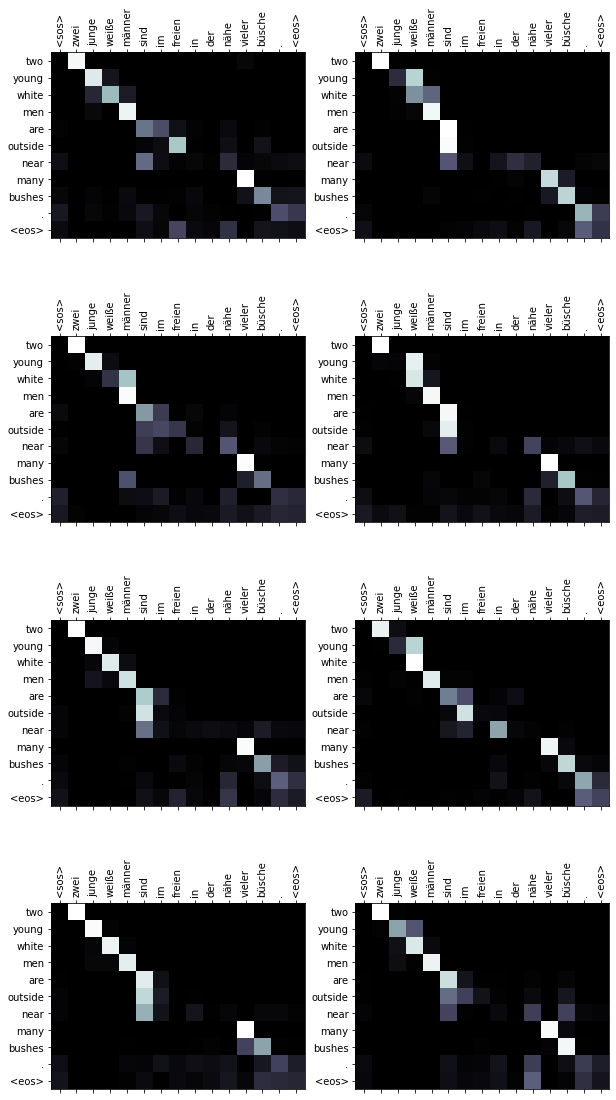

In [35]:
ex_idx = 0
src_tokens = train_data[ex_idx].src
trg_tokens = train_data[ex_idx].trg
src_tokens = [SRC.init_token] + src_tokens + [SRC.eos_token]
trans_tokens, dec_enc_attens = translate(model, src_tokens)
dec_enc_attens = (dec_enc_attens.cpu().numpy() if dec_enc_attens.device.type == 'cuda' else dec_enc_attens.numpy())

print(" ".join(src_tokens))
print(" ".join(trans_tokens))
print(" ".join(trg_tokens))

plot_attention(src_tokens, trans_tokens, dec_enc_attens)

<sos> mehrere männer mit schutzhelmen bedienen ein antriebsradsystem . <eos>
several men in hard hats are operating a <unk> . <eos>
several men in hard hats are operating a giant pulley system .


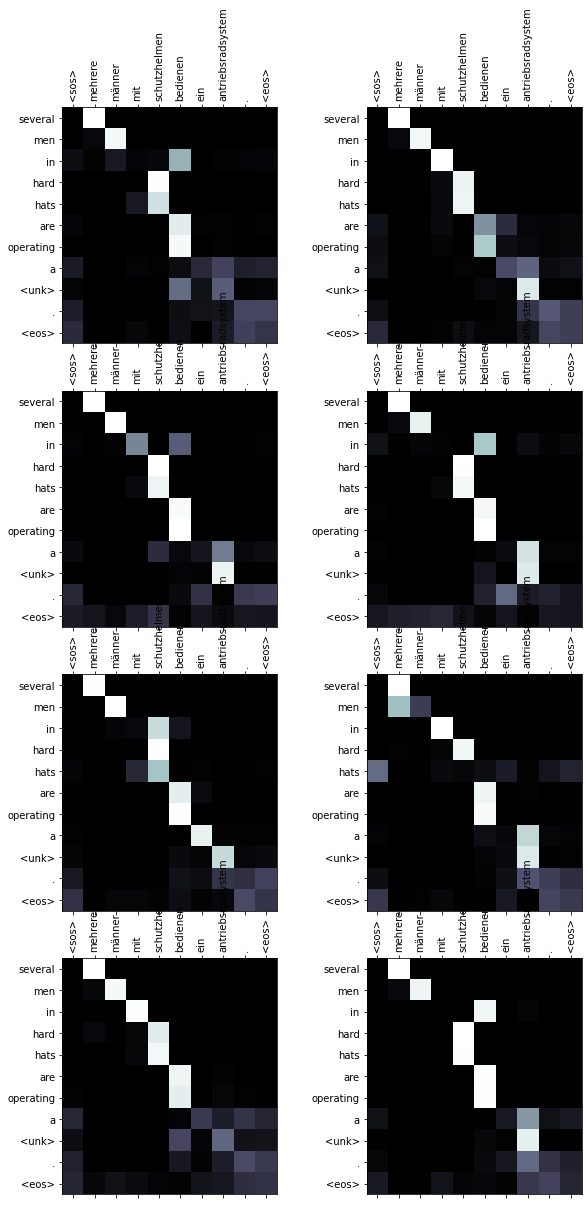

In [36]:
ex_idx = 1
src_tokens = train_data[ex_idx].src
trg_tokens = train_data[ex_idx].trg
src_tokens = [SRC.init_token] + src_tokens + [SRC.eos_token]
trans_tokens, dec_enc_attens = translate(model, src_tokens)
dec_enc_attens = (dec_enc_attens.cpu().numpy() if dec_enc_attens.device.type == 'cuda' else dec_enc_attens.numpy())

print(" ".join(src_tokens))
print(" ".join(trans_tokens))
print(" ".join(trg_tokens))

plot_attention(src_tokens, trans_tokens, dec_enc_attens)

<sos> ein kleines mädchen klettert in ein spielhaus aus holz . <eos>
a little girl climbs into a wooden playhouse . <eos>
a little girl climbing into a wooden playhouse .


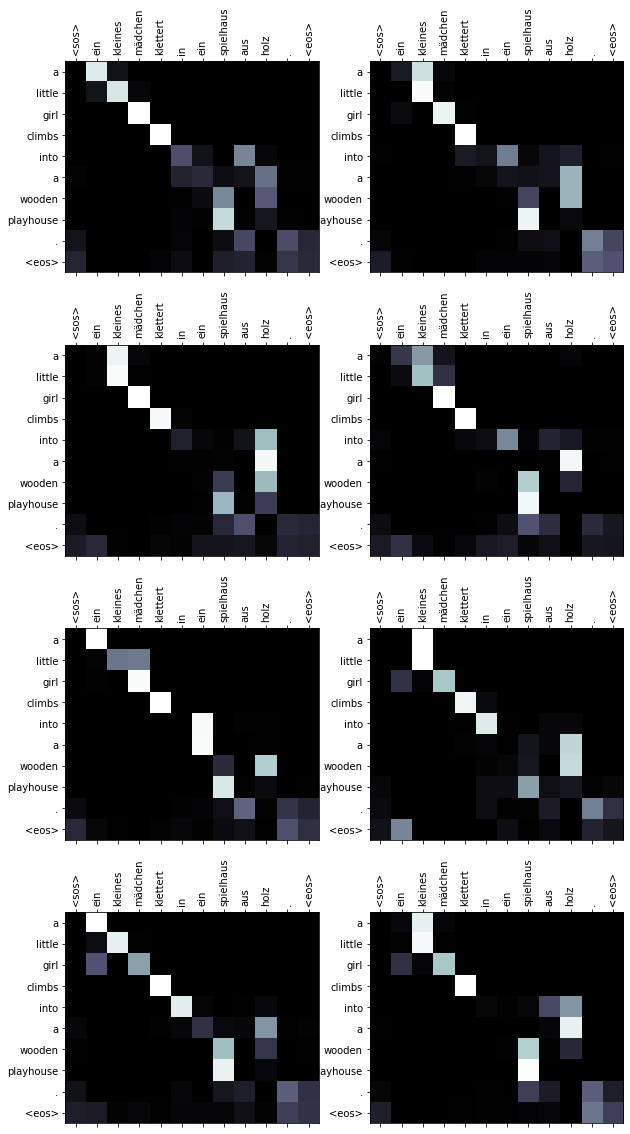

In [37]:
ex_idx = 2
src_tokens = train_data[ex_idx].src
trg_tokens = train_data[ex_idx].trg
src_tokens = [SRC.init_token] + src_tokens + [SRC.eos_token]
trans_tokens, dec_enc_attens = translate(model, src_tokens)
dec_enc_attens = (dec_enc_attens.cpu().numpy() if dec_enc_attens.device.type == 'cuda' else dec_enc_attens.numpy())

print(" ".join(src_tokens))
print(" ".join(trans_tokens))
print(" ".join(trg_tokens))

plot_attention(src_tokens, trans_tokens, dec_enc_attens)

<sos> ein mann in einem blauen hemd steht auf einer leiter und putzt ein fenster . <eos>
a man in a blue shirt is standing on a ladder cleaning a window . <eos>
a man in a blue shirt is standing on a ladder cleaning a window .


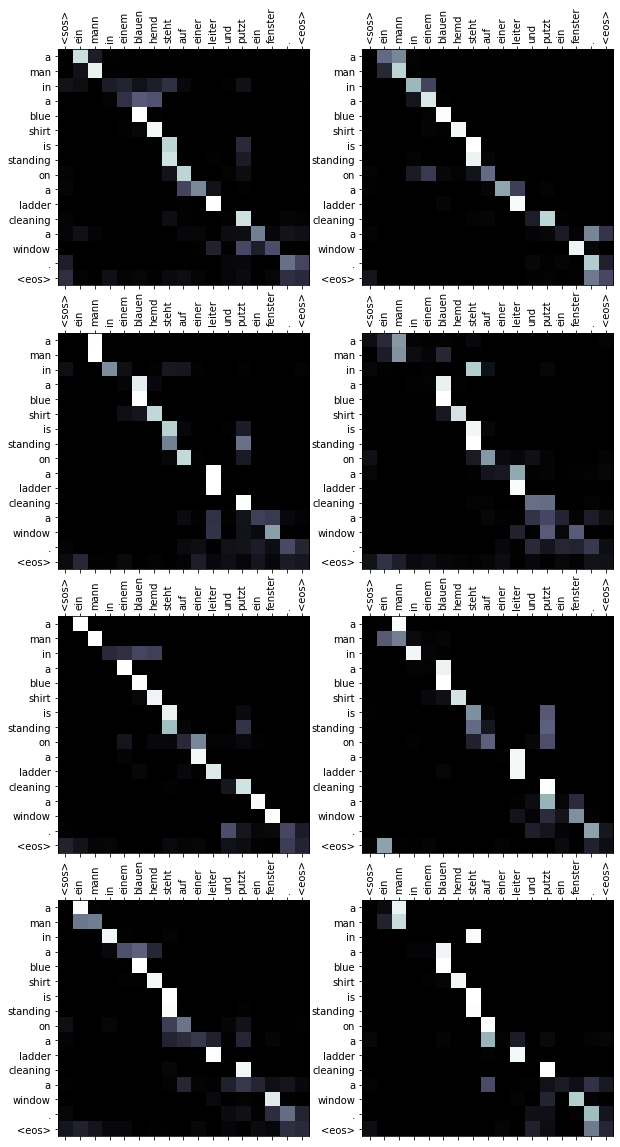

In [38]:
ex_idx = 3
src_tokens = train_data[ex_idx].src
trg_tokens = train_data[ex_idx].trg
src_tokens = [SRC.init_token] + src_tokens + [SRC.eos_token]
trans_tokens, dec_enc_attens = translate(model, src_tokens)
dec_enc_attens = (dec_enc_attens.cpu().numpy() if dec_enc_attens.device.type == 'cuda' else dec_enc_attens.numpy())

print(" ".join(src_tokens))
print(" ".join(trans_tokens))
print(" ".join(trg_tokens))

plot_attention(src_tokens, trans_tokens, dec_enc_attens)

## BLEU

*BLEU* (Bilingual Evaluation Understudy) is a metric measuring the quality of translation.  
BLEU looks at the overlap in the predicted and actual target sequences in terms of their *n-grams*.  
BLEU gives a number between 0 and 1 for each sequence, and a higher BLEU suggests better translation quality.  
BLEU being 1 means a perfect overlap, i.e., a perfect translation.  

In [39]:
from torchtext.data.metrics import bleu_score

def calc_bleu(data):
    trg_data = []
    trans_data = []
    for ex in data:
        src_tokens = ex.src
        trg_tokens = ex.trg
        src_tokens = [SRC.init_token] + src_tokens + [SRC.eos_token]
        trans_tokens, attens = translate(model, src_tokens)

        # The groudtruth may contain multiple actual sentences (right translations). 
        trg_data.append([trg_tokens])
        trans_data.append(trans_tokens[:-1])  # Cut off the <eos> token

    return bleu_score(trans_data, trg_data)

In [40]:
bleu = calc_bleu(test_data)

print(f'BLEU score is: {bleu*100:.2f}')

BLEU score is: 35.67
